In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import numpy as np
from PIL import Image
# import polars as pd
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random
import timeit
from tqdm import tqdm
from vit.model import ViT
from vit.fourier_vit import SpectreViT

In [ ]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 50
# LEARNING_RATE = 1e-4
LEARNING_RATE = 1e-3
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 32
DROPOUT = 0.001
HIDDEN_DIM = 64
# HIDDEN_DIM = 8
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = 'gelu'
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE**2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49
USE_SPECTRE=True
SPECTRE_THRESHOLD=1.0
USE_SPECTRE_VIT=True

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [ ]:
# Test ViT
# model = ViT(IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
if USE_SPECTRE_VIT:
    model = SpectreViT(img_size=IMG_SIZE, patch_size=PATCH_SIZE, in_channels=IN_CHANNELS, 
                num_classes=NUM_CLASSES, embed_dim=EMBED_DIM, num_encoders=NUM_ENCODERS, 
                num_heads=NUM_HEADS, hidden_dim=HIDDEN_DIM, dropout=DROPOUT, activation=ACTIVATION,
                use_spectre=USE_SPECTRE, spectre_threshold=SPECTRE_THRESHOLD).to(device)
else:
    model = ViT(img_size=IMG_SIZE, patch_size=PATCH_SIZE, in_channels=IN_CHANNELS, 
                num_classes=NUM_CLASSES, embed_dim=EMBED_DIM, num_encoders=NUM_ENCODERS, 
                num_heads=NUM_HEADS, hidden_dim=HIDDEN_DIM, dropout=DROPOUT, activation=ACTIVATION,
                use_spectre=USE_SPECTRE, spectre_threshold=SPECTRE_THRESHOLD).to(device)
# Print model params number
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
torch.save(model.state_dict(), 'vit_spectre_test.pt')

2834


In [ ]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")
submission_df = pd.read_csv("./data/sample_submission.csv")

In [ ]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [ ]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        super().__init__()
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transofrm = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        
        image = self.transofrm(image)
        
        return {'image': image, 'label': label, 'index': index}
    

class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        super().__init__()
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transofrm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        
        image = self.transofrm(image)
        
        return {'image': image, 'label': label, 'index': index}
       
class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indicies):
        super().__init__()
        self.images = images
        self.indicies = indicies
        self.transofrm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transofrm(image)
        
        return {'image': image, 'index': index}

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

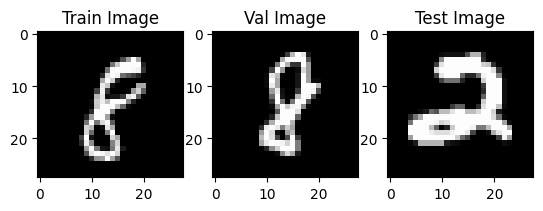

In [ ]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]['image'].squeeze(), cmap='gray')
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]['image'].squeeze(), cmap='gray')
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]['image'].squeeze(), cmap='gray')
axarr[2].set_title("Test Image")
print("-"*30)

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
use_amp = True

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)
optimizer = optim.AdamW(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)
scaler = torch.amp.GradScaler("cuda", enabled=use_amp)
start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            train_labels.extend(label.cpu().detach())
            train_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        # optimizer.step()

        train_running_loss += loss.item()

    train_loss = train_running_loss / (idx + 1)
    
    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)
            
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
            
    
        val_loss = val_running_loss /  (idx + 1)
    
        print("-"*30)
        print(f"Train Loss EPOCH {epoch + 1}: {train_loss:.4f}")
        print(f"Val Loss EPOCH {epoch + 1}: {val_loss:.4f}")
        print(f"Train Accuracy EPOCH {epoch + 1}: {sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
        print(f"Val Accuracy EPOCH {epoch + 1}: {sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
        print("-"*30)

    
stop = timeit.default_timer()
print(f"Training time: {stop - start:.2f}")

100%|██████████| 1/1 [00:07<00:00,  7.20s/it]

------------------------------
Train Loss EPOCH 1: 0.7402
Val Loss EPOCH 1: 0.5957
Train Accuracy EPOCH 1: 0.8010
Val Accuracy EPOCH 1: 0.8360
------------------------------
Training time: 7.20


In [ ]:
torch.cuda.empty_cache()

In [ ]:
labels = []
ids = []
imgs = []
model.eval()

with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i) + 1 for i in sample["index"]])
        
        outputs = model(img)
        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])
        

100%|██████████| 55/55 [00:01<00:00, 27.77it/s]


<Figure size 640x480 with 0 Axes>

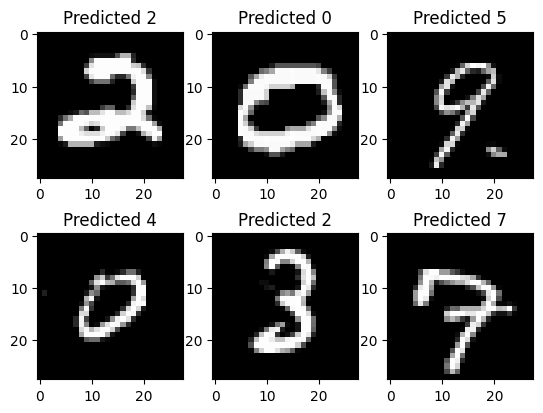

In [ ]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap='gray')
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1
        
plt.show()